In [1]:
import qiskit

In [2]:
pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

  Cloning https://github.com/qiskit-community/qiskit-textbook.git to c:\users\anirudh\appdata\local\temp\pip-req-build-ouruia01
  Created wheel for qiskit-textbook: filename=qiskit_textbook-0.1.0-py3-none-any.whl size=17069 sha256=8c29e8cdc338a3c272867697de19147ab92d097cea5fc4a08ead279a92281bfd
  Stored in directory: C:\Users\ANIRUDH\AppData\Local\Temp\pip-ephem-wheel-cache-ayca2fp1\wheels\80\c4\dd\b7ea1ee2a7247e8997db78bc777bbe22e61ab1e5ed1c4b46e1
Successfully built qiskit-textbook
Note: you may need to restart the kernel to use updated packages.


In [3]:
from qiskit import IBMQ
IBMQ.save_account('c81b6ab5c814d3a62d6c5e9b6fd7bb399a602777eb49f83e1578c6928a03819c462cd75b67812ca14d3e48733e00525180a6cda445774766f5d012c1758a10ec', overwrite=True)

In [5]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')


C:\Users\ANIRUDH\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [6]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"


In [7]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds


Sampling time: 0.2222222222222222 ns


In [8]:
backend_defaults = backend.defaults()


In [9]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")


Qubit 0 has an estimated frequency of 4.974446855948306 GHz.
The sweep will go from 4.954446855948306 GHz to 4.994446855948306 GHz in steps of 1.0 MHz.


In [10]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)


In [11]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')


<ipython-input-11-1aae8bf078ff>:3: DeprecationWarning: the pulse_lib module is deprecated, pulse_lib is renamed to library
  from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


In [12]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"


In [13]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])


In [14]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)


In [15]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]


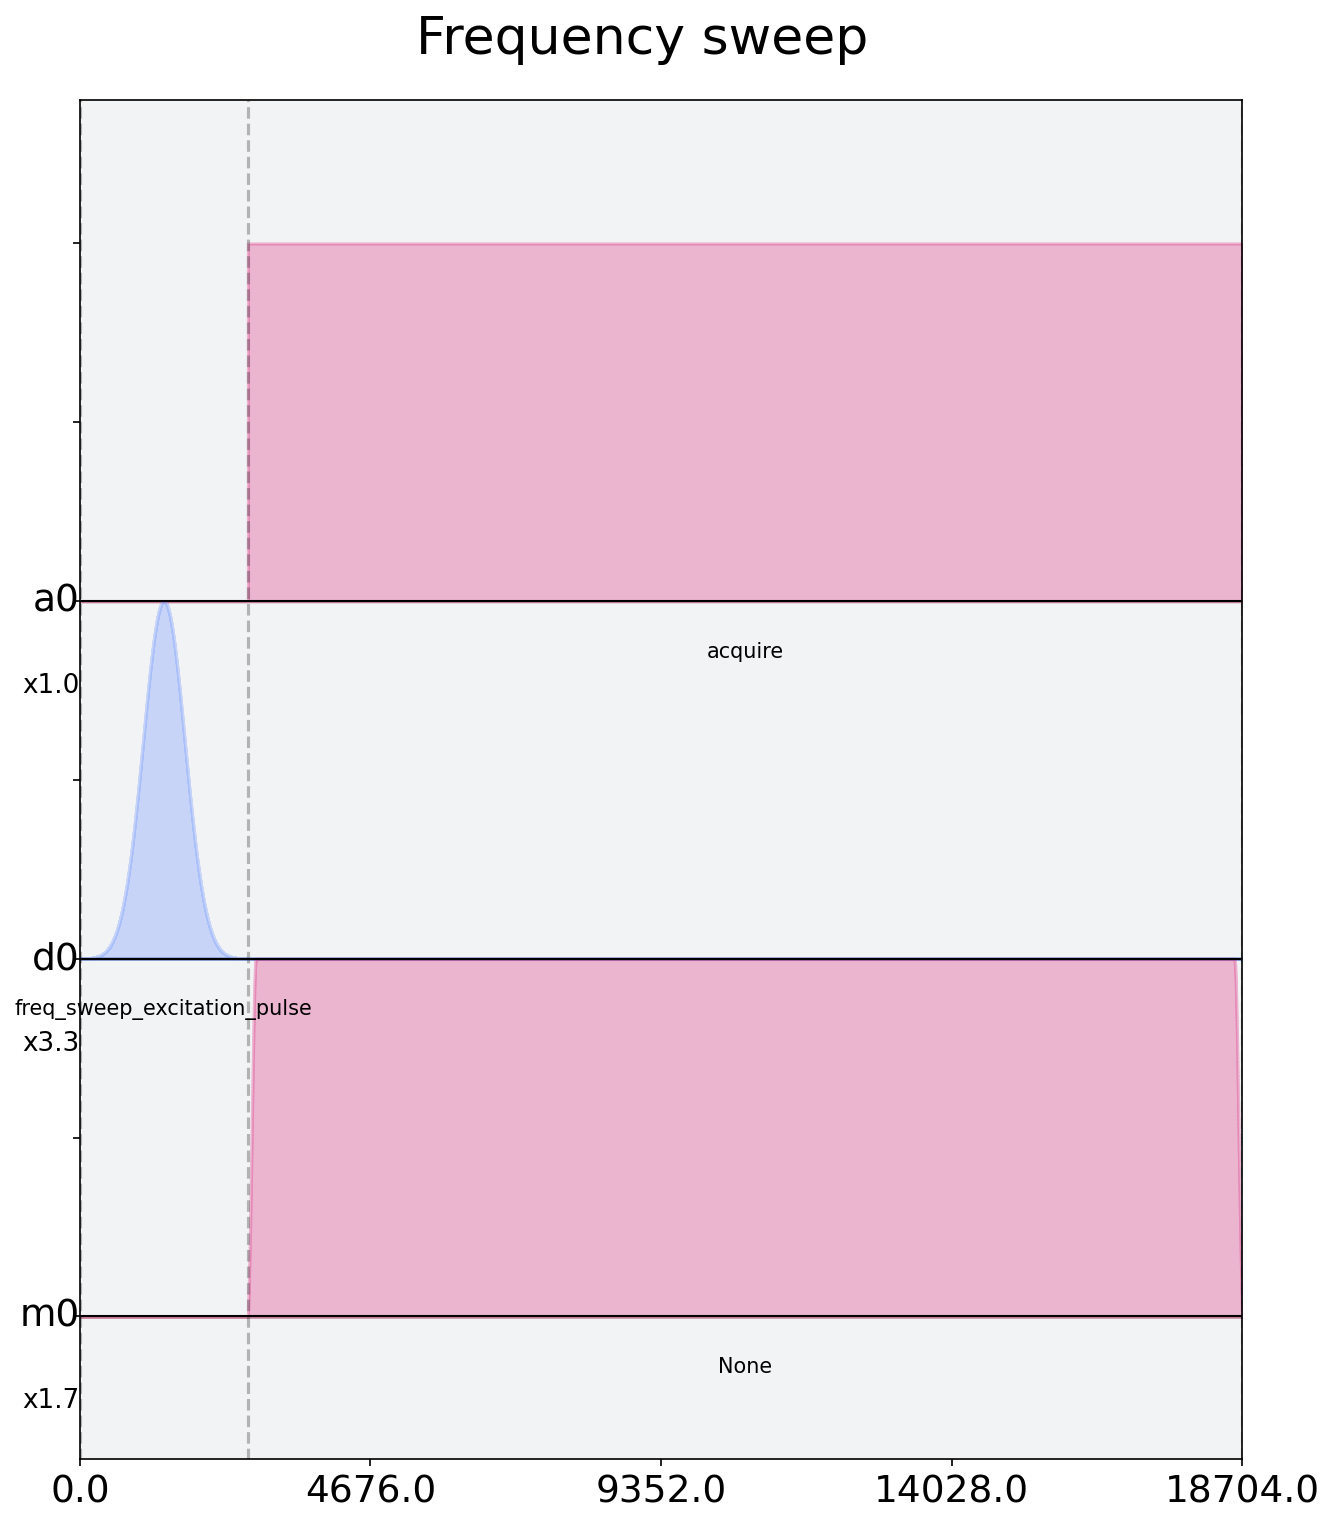

In [16]:
schedule.draw(label=True)


In [17]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)


In [18]:
job = backend.run(frequency_sweep_program)


In [19]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)


Job Status: job has successfully run


In [20]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds


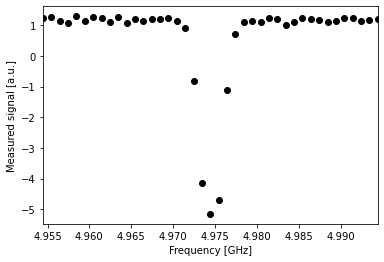

In [21]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()


In [22]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit


In [23]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 3] # initial parameters for curve_fit
                                )


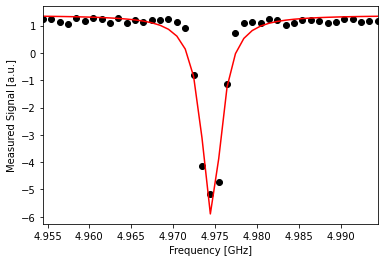

In [24]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()


In [25]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")


We've updated our qubit frequency estimate from 4.97445 GHz to 4.97456 GHz.


In [26]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)


In [27]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)


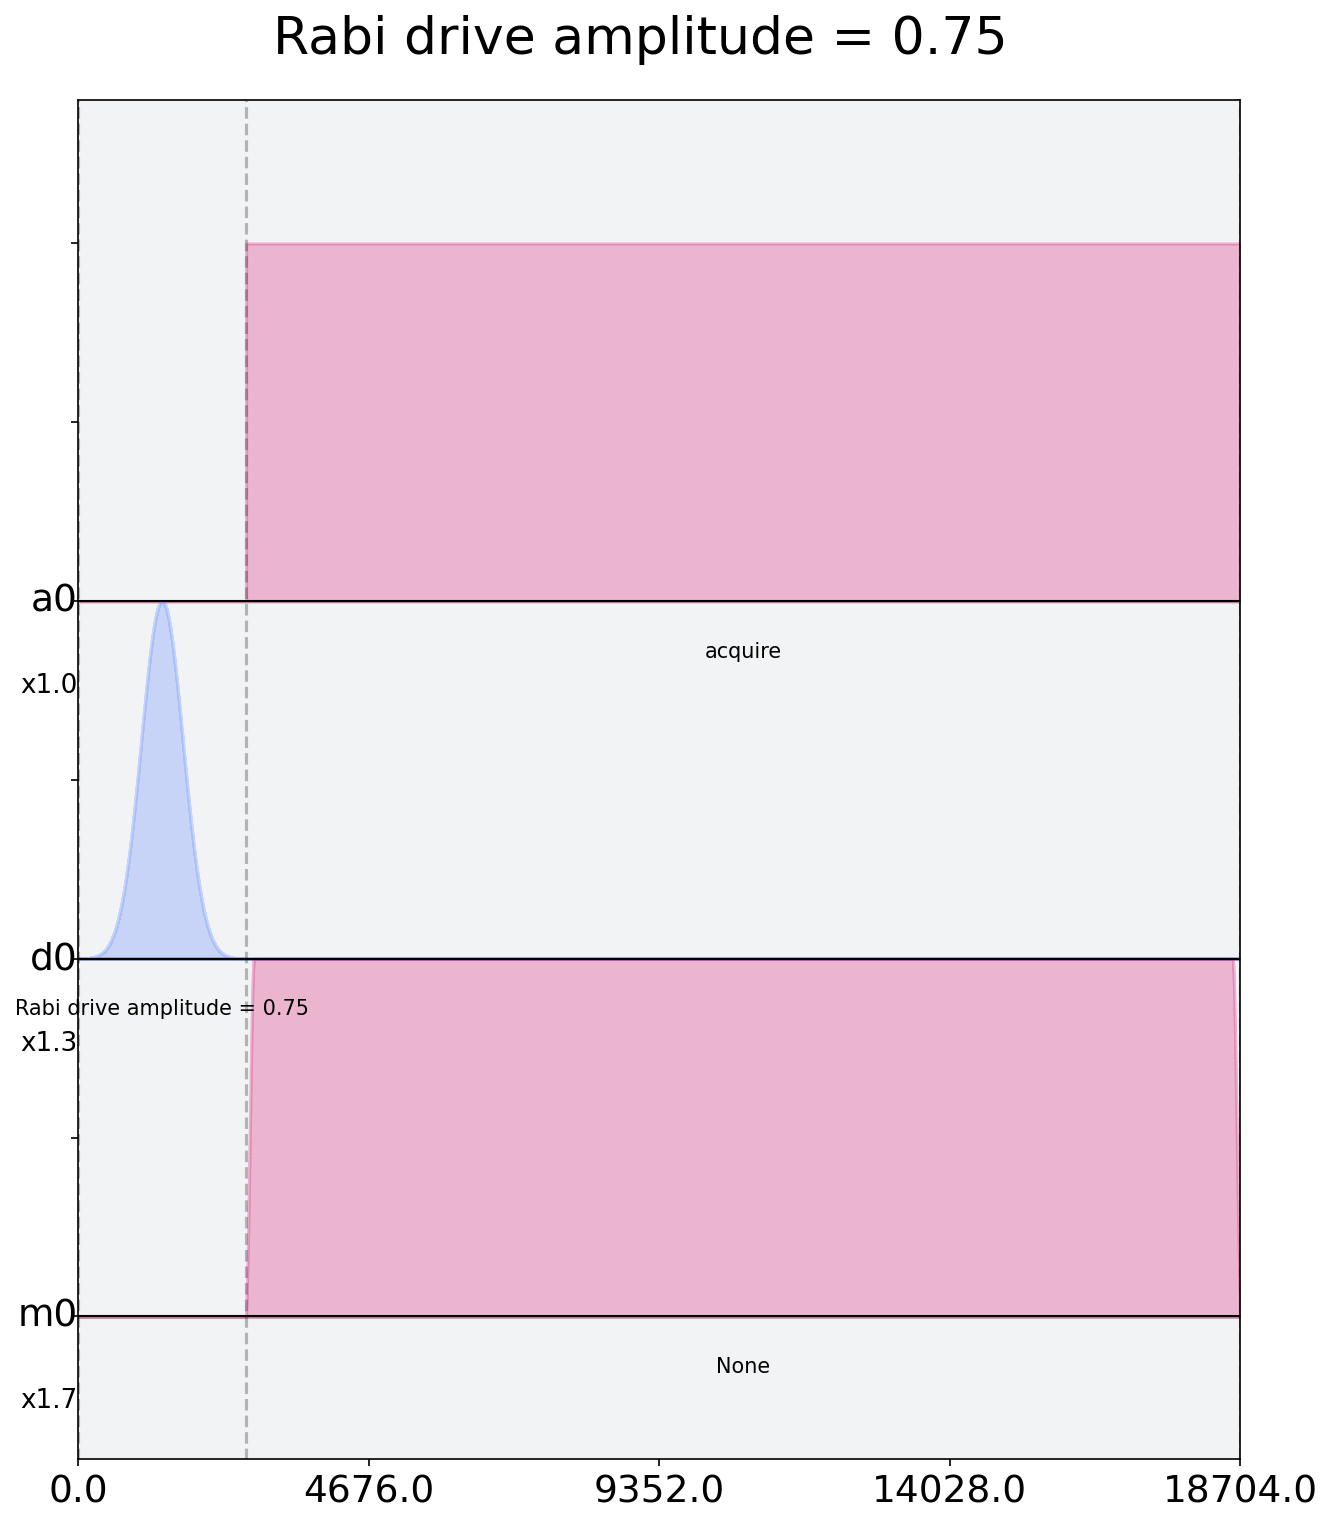

In [28]:
rabi_schedules[-1].draw(label=True)


In [29]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)


In [30]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)


5fd5ff1d8053830019b34eb3
Job Status: job has successfully run


In [31]:
rabi_results = job.result(timeout=120)


In [32]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)


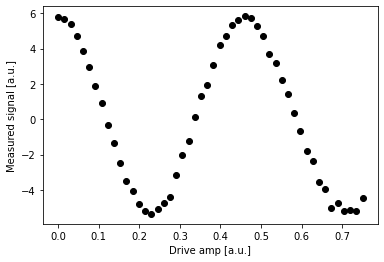

In [33]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()


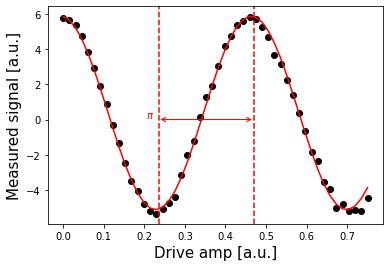

In [34]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()


In [35]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.23505861719773935


In [36]:
pi_pulse = pulse_lib.gaussian(duration=drive_samples,
                              amp=pi_amp, 
                              sigma=drive_sigma,
                              name='pi_pulse')


In [37]:
gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure
exc_schedule = pulse.Schedule(name="excited state")
exc_schedule += Play(pi_pulse, drive_chan)
exc_schedule += measure << exc_schedule.duration

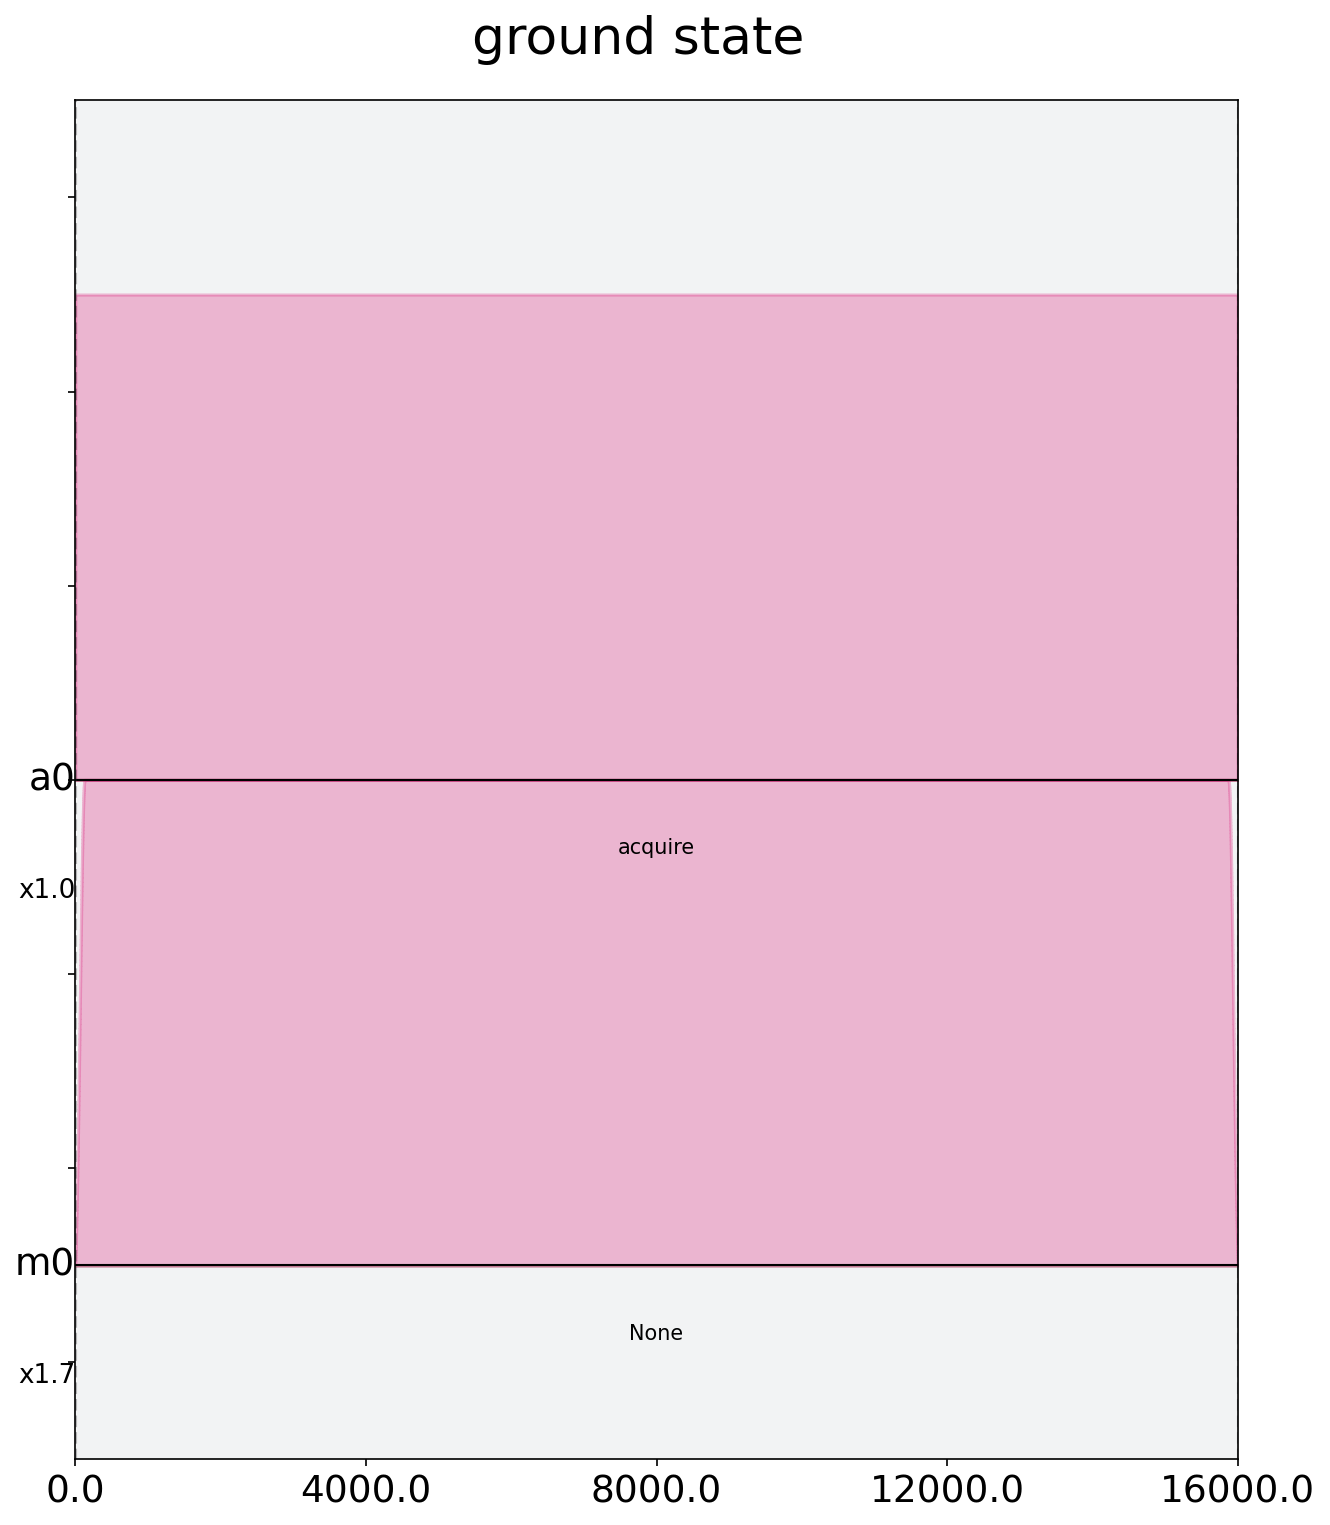

In [38]:
gnd_schedule.draw(label=True)

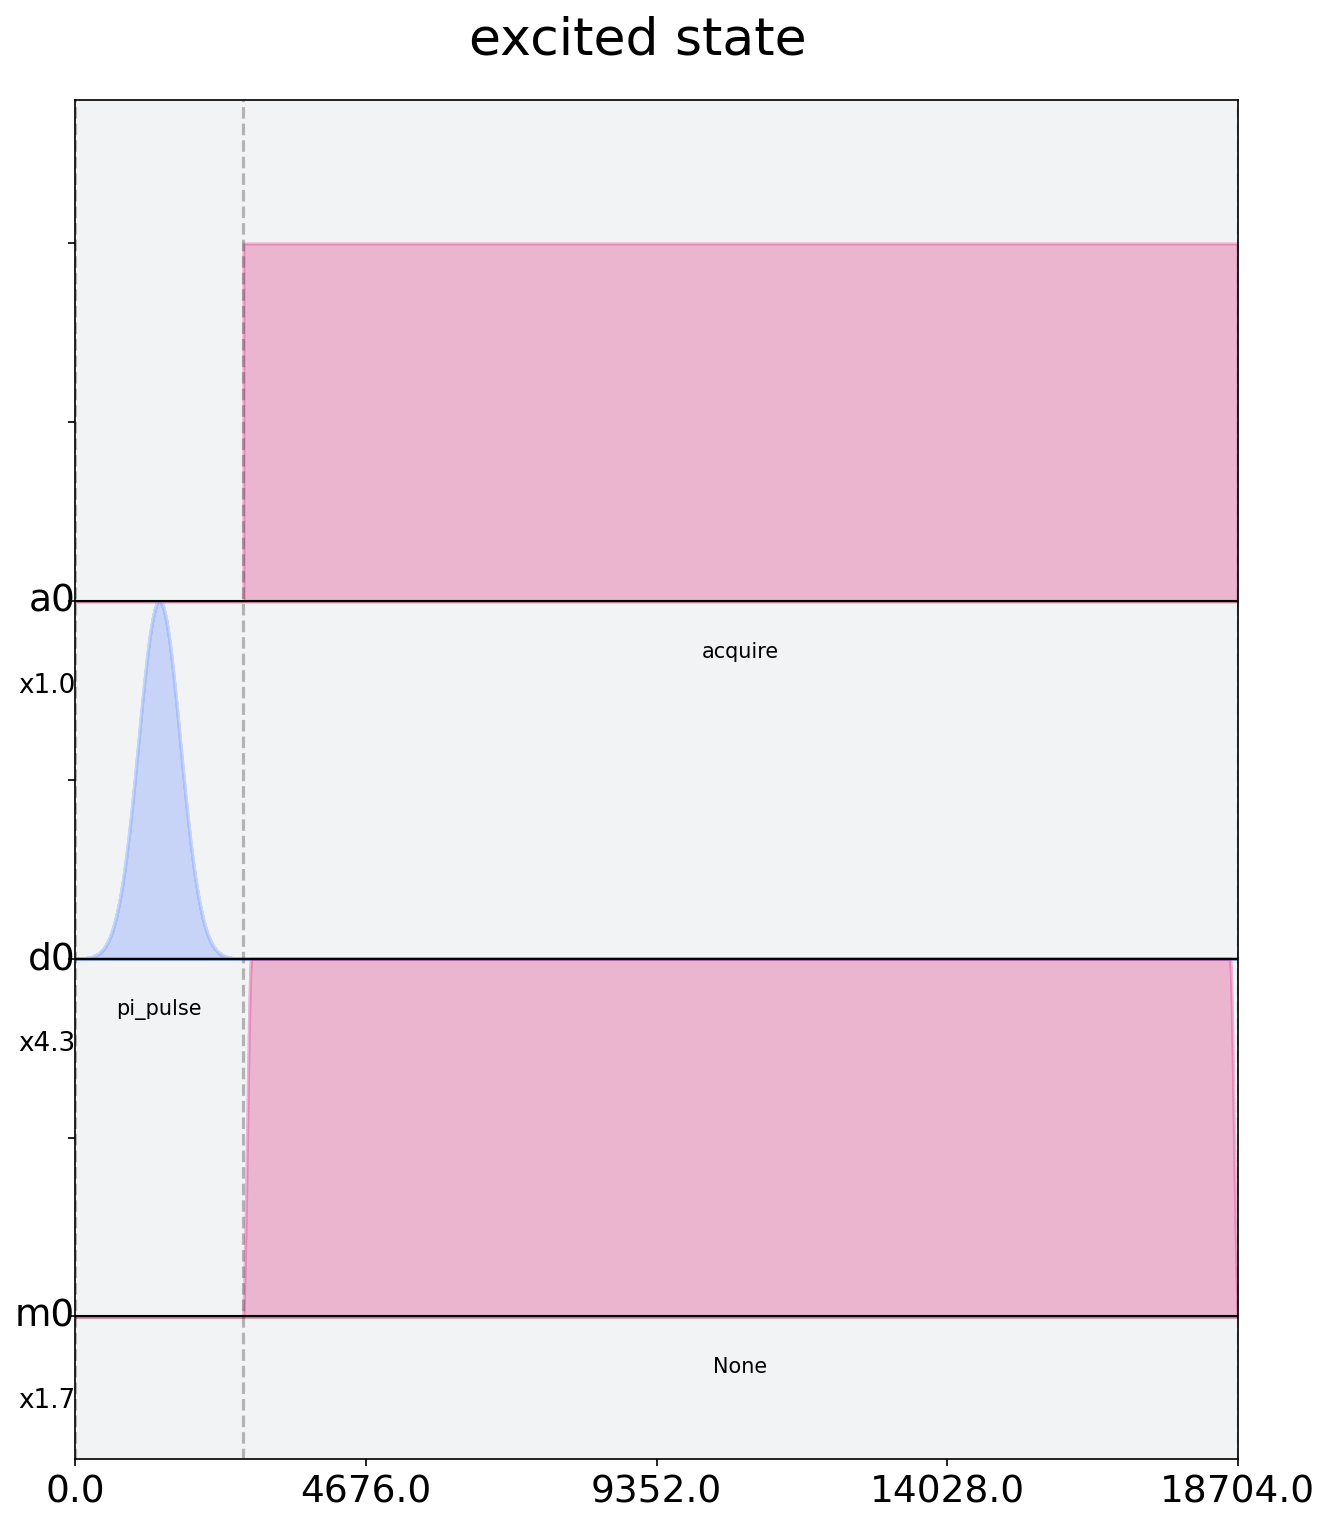

In [39]:
exc_schedule.draw(label=True)

In [40]:
# Execution settings
num_shots = 1024

gnd_exc_program = assemble([gnd_schedule, exc_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=num_shots,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)


In [42]:
# print(job.job_id())
job = backend.run(gnd_exc_program)
job_monitor(job)


Job Status: job has successfully run


In [43]:
gnd_exc_results = job.result(timeout=120)


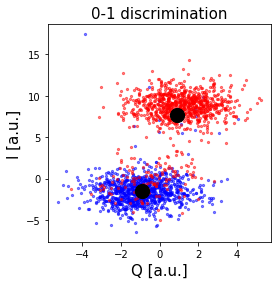

In [44]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()


In [45]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))


In [46]:
# T1 experiment parameters
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt
# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before


In [47]:
# Create schedules for the experiment 
t1_schedules = []
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)


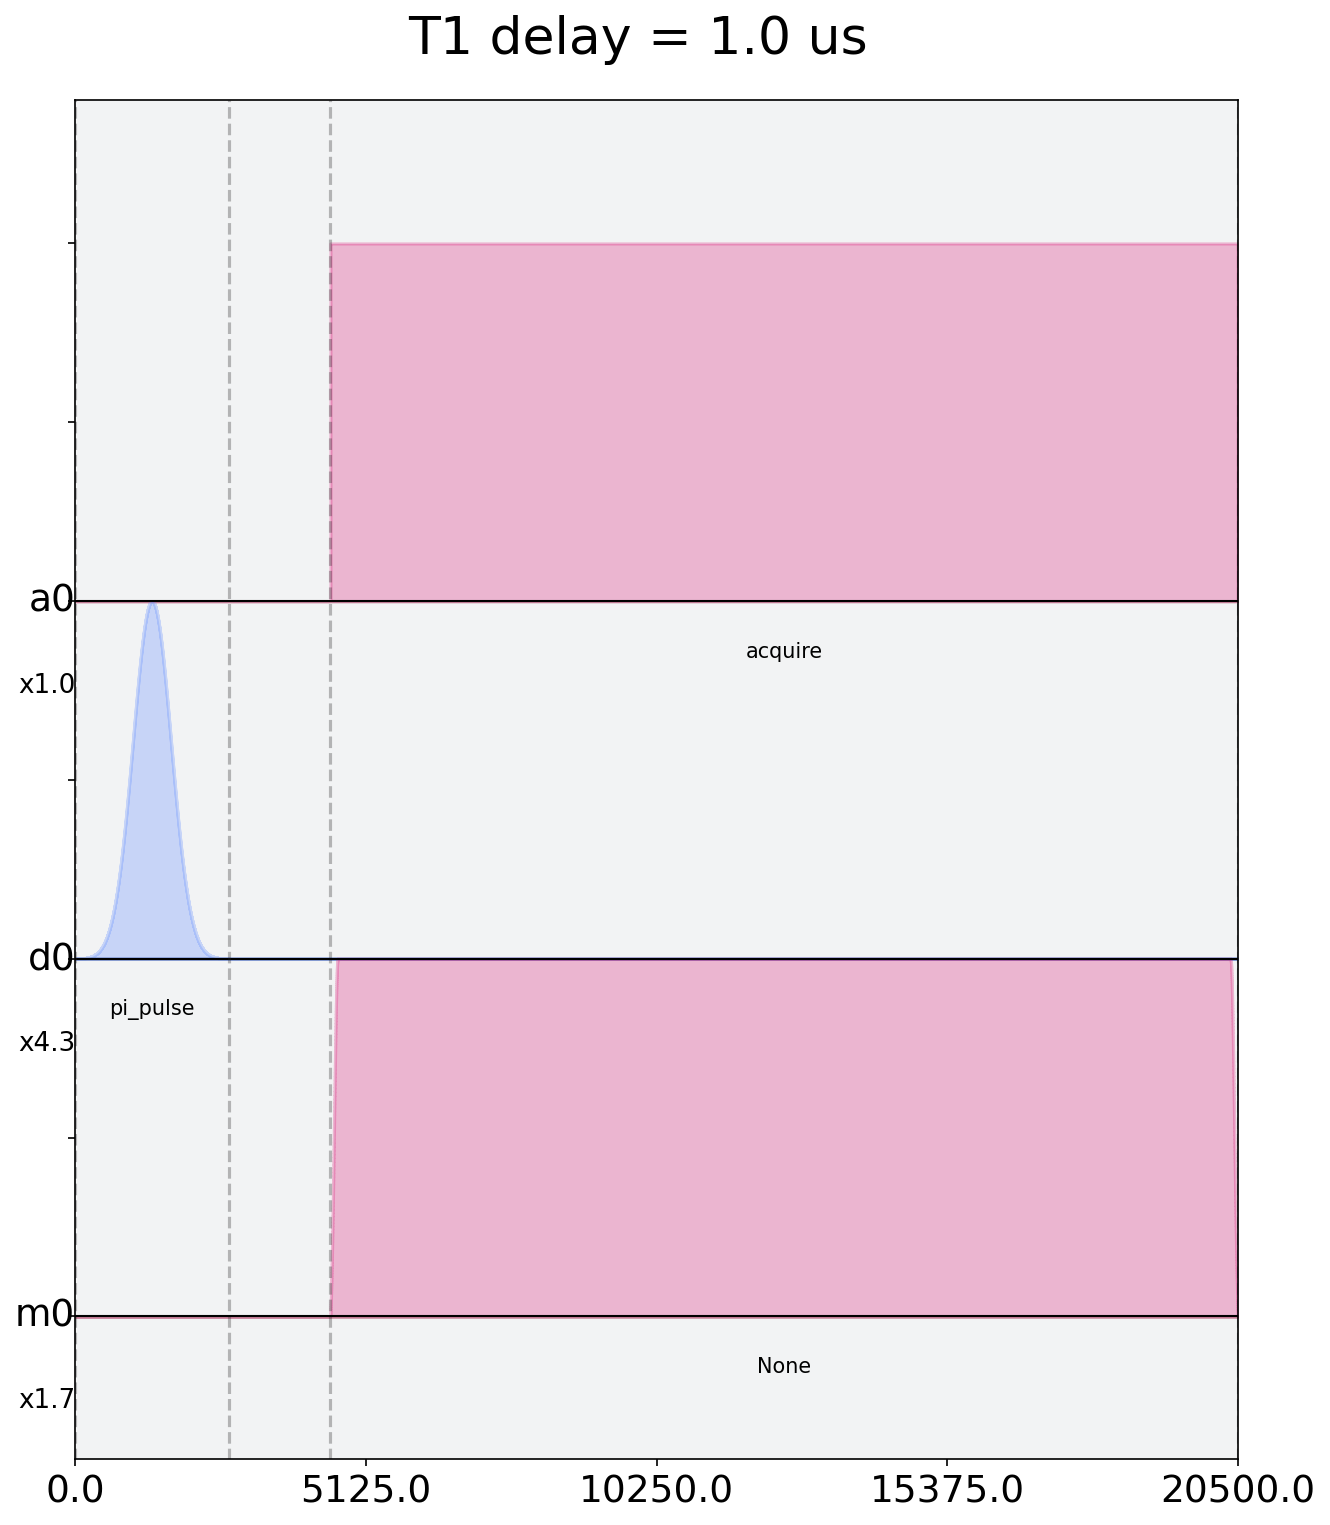

In [48]:
sched_idx = 0
t1_schedules[sched_idx].draw(label=True)


In [49]:
# Execution settings
num_shots = 256

t1_experiment = assemble(t1_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_frequency}] * len(t1_schedules))


In [50]:
job = backend.run(t1_experiment)
job_monitor(job)

Job Status: job has successfully run


In [51]:
t1_results = job.result(timeout=120)

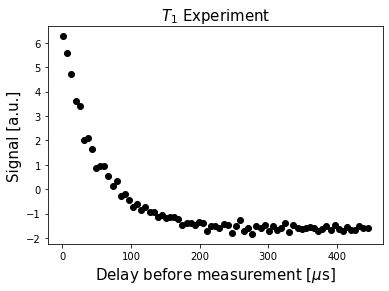

In [52]:
t1_values = []
for i in range(len(times_us)):
    t1_values.append(t1_results.get_memory(i)[qubit]*scale_factor)
t1_values = np.real(t1_values)

plt.scatter(times_us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()


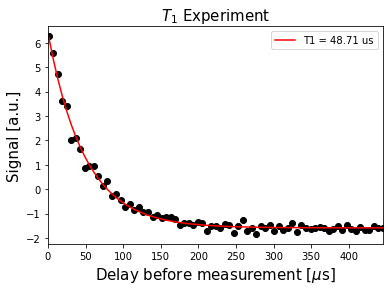

In [53]:
# Fit the data
fit_params, y_fit = fit_function(times_us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(times_us, t1_values, color='black')
plt.plot(times_us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()


In [54]:
# Ramsey experiment parameters
time_max_us = 1.8
time_step_us = 0.025
times_us = np.arange(0.1, time_max_us, time_step_us)
# Convert to units of dt
delay_times_dt = times_us * us / dt

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2
# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
x90_pulse = pulse_lib.gaussian(duration=drive_samples,
                               amp=drive_amp, 
                               sigma=drive_sigma,
                               name='x90_pulse')


In [55]:
# create schedules for Ramsey experiment 
ramsey_schedules = []

for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"Ramsey delay = {delay * dt / us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)

    ramsey_schedules.append(this_schedule)


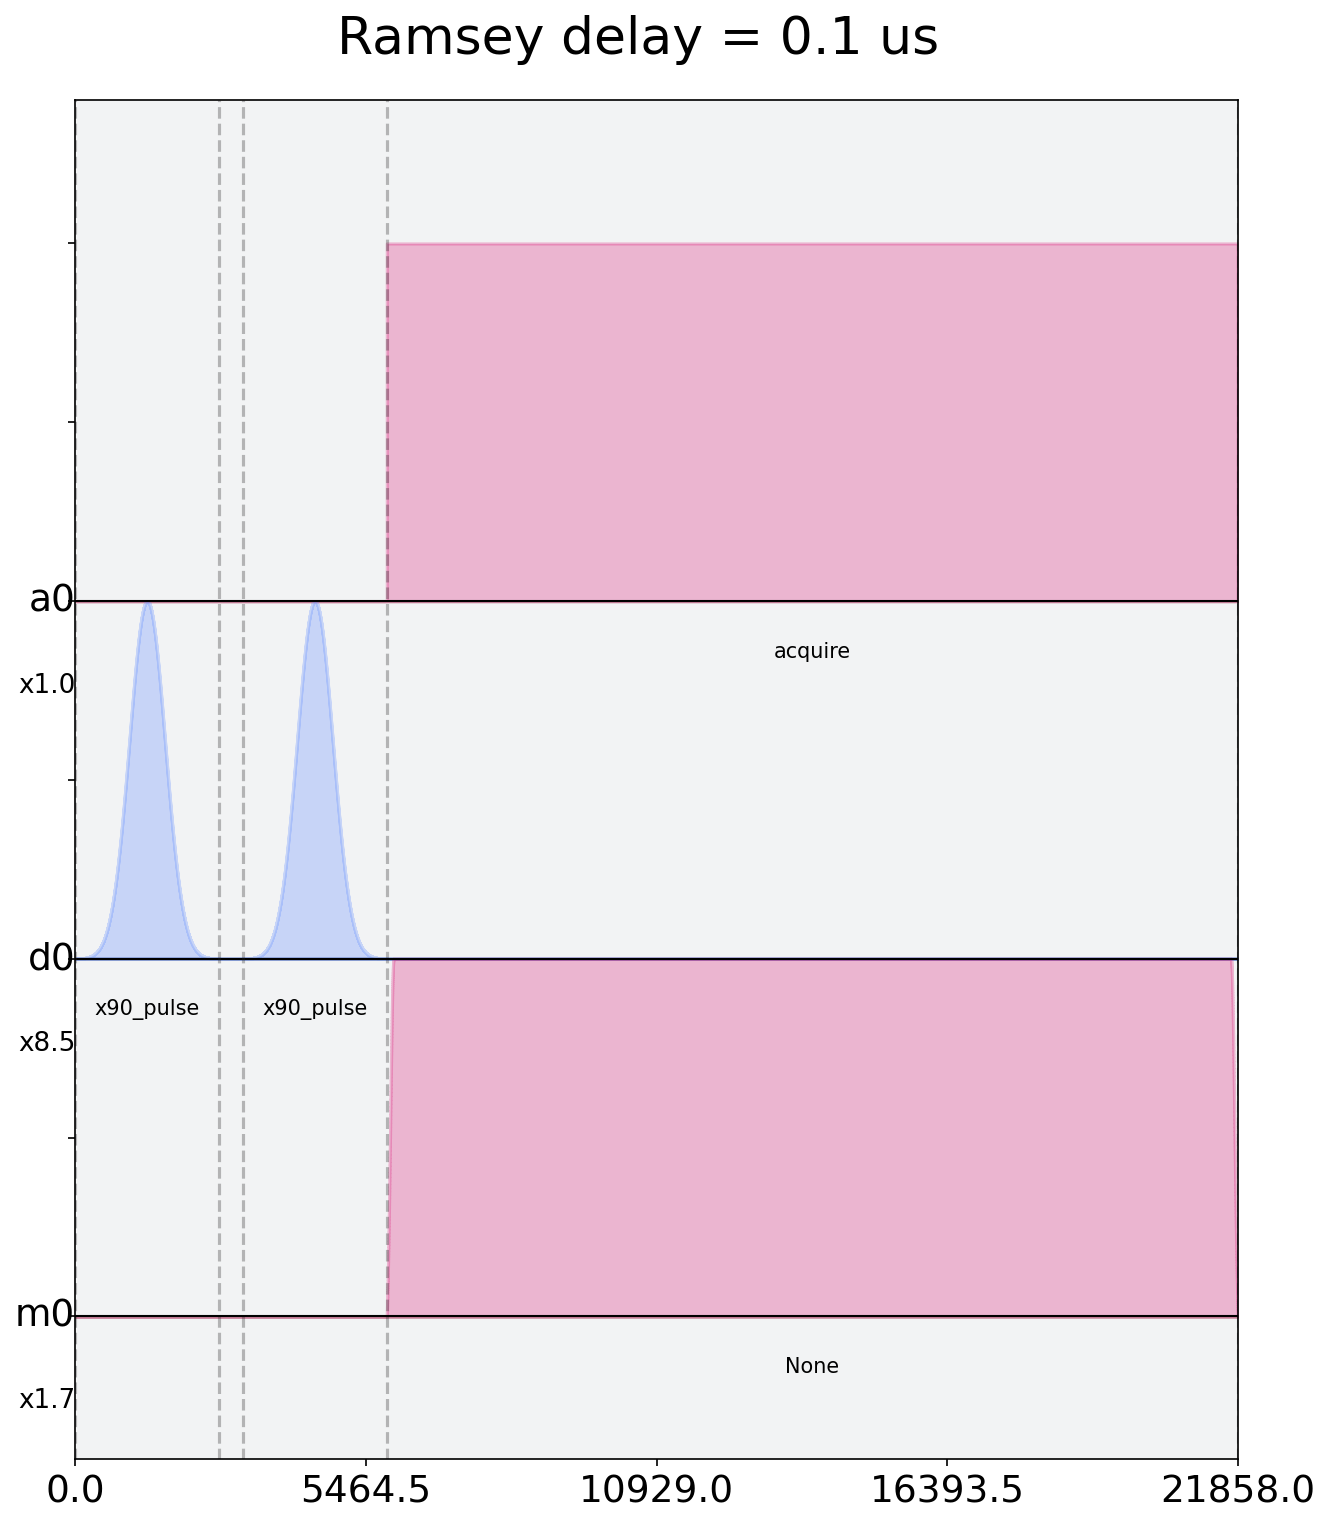

In [56]:
ramsey_schedules[0].draw(label=True)


In [57]:
# Execution settings
num_shots = 256

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz
ramsey_program = assemble(ramsey_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots,
                             schedule_los=[{drive_chan: ramsey_frequency}]*len(ramsey_schedules)
                            )


In [58]:
job = backend.run(ramsey_program)
job_monitor(job)

Job Status: job has successfully run


In [59]:
ramsey_results = job.result(timeout=120)

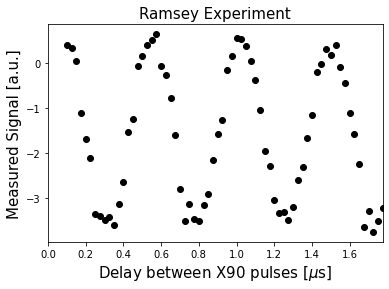

In [60]:
ramsey_values = []
for i in range(len(times_us)):
    ramsey_values.append(ramsey_results.get_memory(i)[qubit]*scale_factor)
    
plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(times_us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


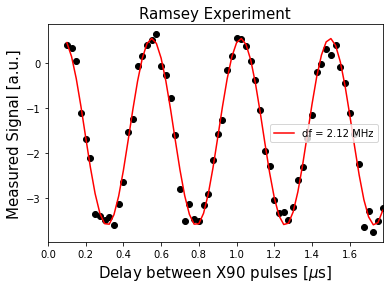

In [61]:
fit_params, y_fit = fit_function(times_us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [5, 1./0.4, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(times_us, np.real(ramsey_values), color='black')
plt.plot(times_us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(times_us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()


In [62]:
precise_qubit_freq = rough_qubit_frequency + (del_f_MHz - detuning_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")


Our updated qubit frequency is now 4.974679 GHz. It used to be 4.974564 GHz


In [63]:
# T2 experiment parameters
tau_max_us = 200
tau_step_us = 4
taus_us = np.arange(2, tau_max_us, tau_step_us)
# Convert to units of dt
delay_times_dt = taus_us * us / dt

# We will use the pi_pulse and x90_pulse from previous experiments


In [64]:
t2_schedules = []
for tau in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T2 delay = {tau *dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + tau)
    this_schedule |= measure << int(this_schedule.duration)
    
    t2_schedules.append(this_schedule)


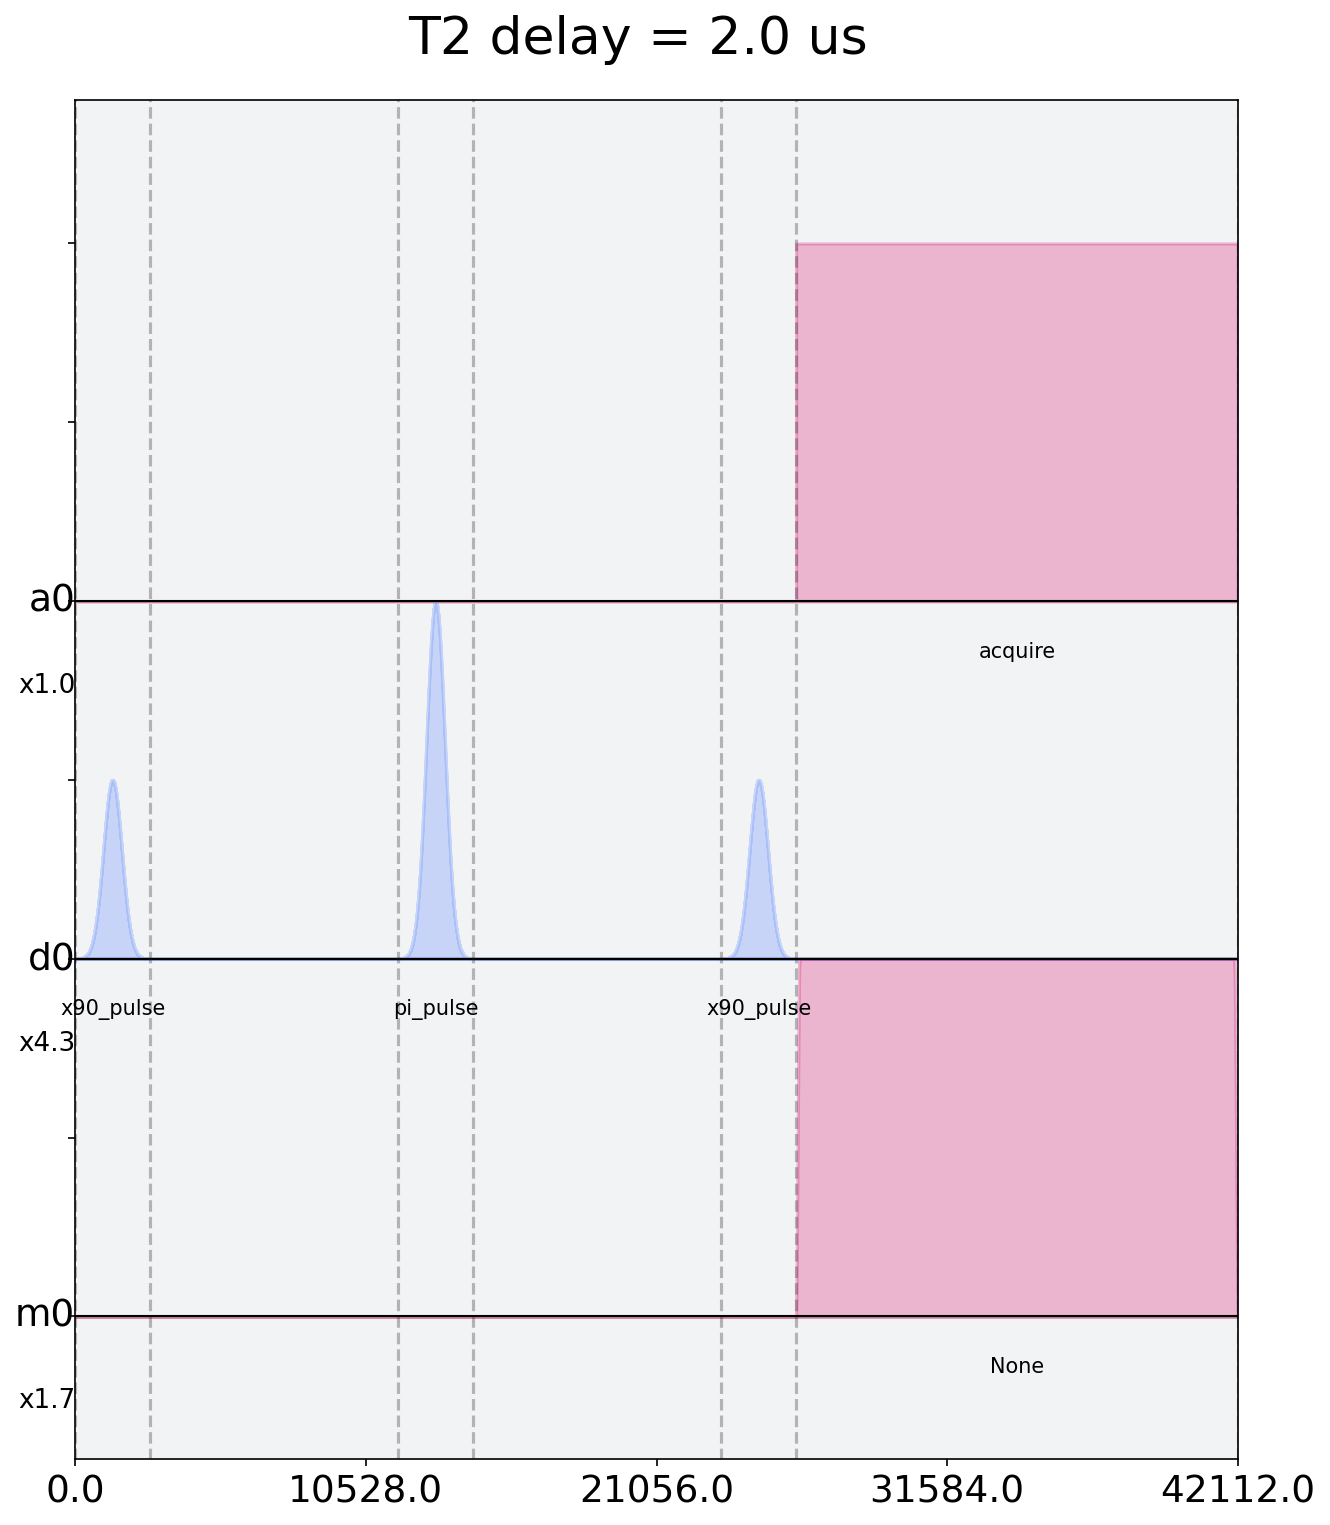

In [65]:
t2_schedules[0].draw(label=True)

In [66]:
# Execution settings
num_shots_per_point = 512

t2_experiment = assemble(t2_schedules,
                         backend=backend,
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots_per_point,
                         schedule_los=[{drive_chan: precise_qubit_freq}]
                                      * len(t2_schedules))


In [67]:
job = backend.run(t2_experiment)
job_monitor(job)

Job Status: job has successfully run


In [68]:
t2_results = job.result(timeout=120)

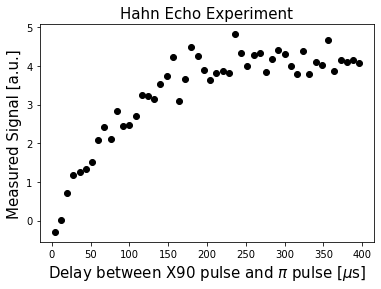

In [69]:
t2_values = []
for i in range(len(taus_us)):
    t2_values.append(t2_results.get_memory(i)[qubit]*scale_factor)

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()


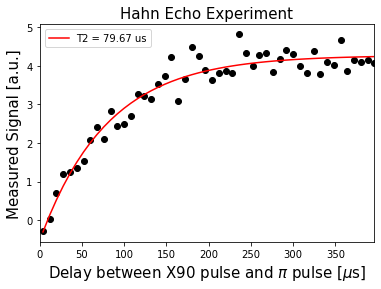

In [70]:
fit_params, y_fit = fit_function(2*taus_us, np.real(t2_values),
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*taus_us, np.real(t2_values), color='black')
plt.plot(2*taus_us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*taus_us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()


In [71]:
# DD experiment parameters
tau_us_min = 1
tau_us_max = 40
tau_step_us = 1.5
taus_us = np.arange(tau_us_min, tau_us_max, tau_step_us)
# Convert to units of dt
taus_dt = taus_us * us / dt
num_pi_pulses = 6 # apply 6 pi pulses
print(f"Total time ranges from {2.*num_pi_pulses*taus_us[0]} to {2.*num_pi_pulses*taus_us[-1]} us")


Total time ranges from 12.0 to 462.0 us


In [72]:
T2DD_schedules = []
for delay in taus_dt:
    this_schedule = pulse.Schedule(name=f"T2DD delay = {delay * dt/us} us")
    this_schedule |= Play(x90_pulse, drive_chan)
    this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + delay)

    for _ in range(num_pi_pulses - 1):
        this_schedule |= Play(pi_pulse, drive_chan) << int(this_schedule.duration + 2*delay)

    this_schedule |= Play(x90_pulse, drive_chan) << int(this_schedule.duration + delay)
    this_schedule |= measure << int(this_schedule.duration)
    
    T2DD_schedules.append(this_schedule)


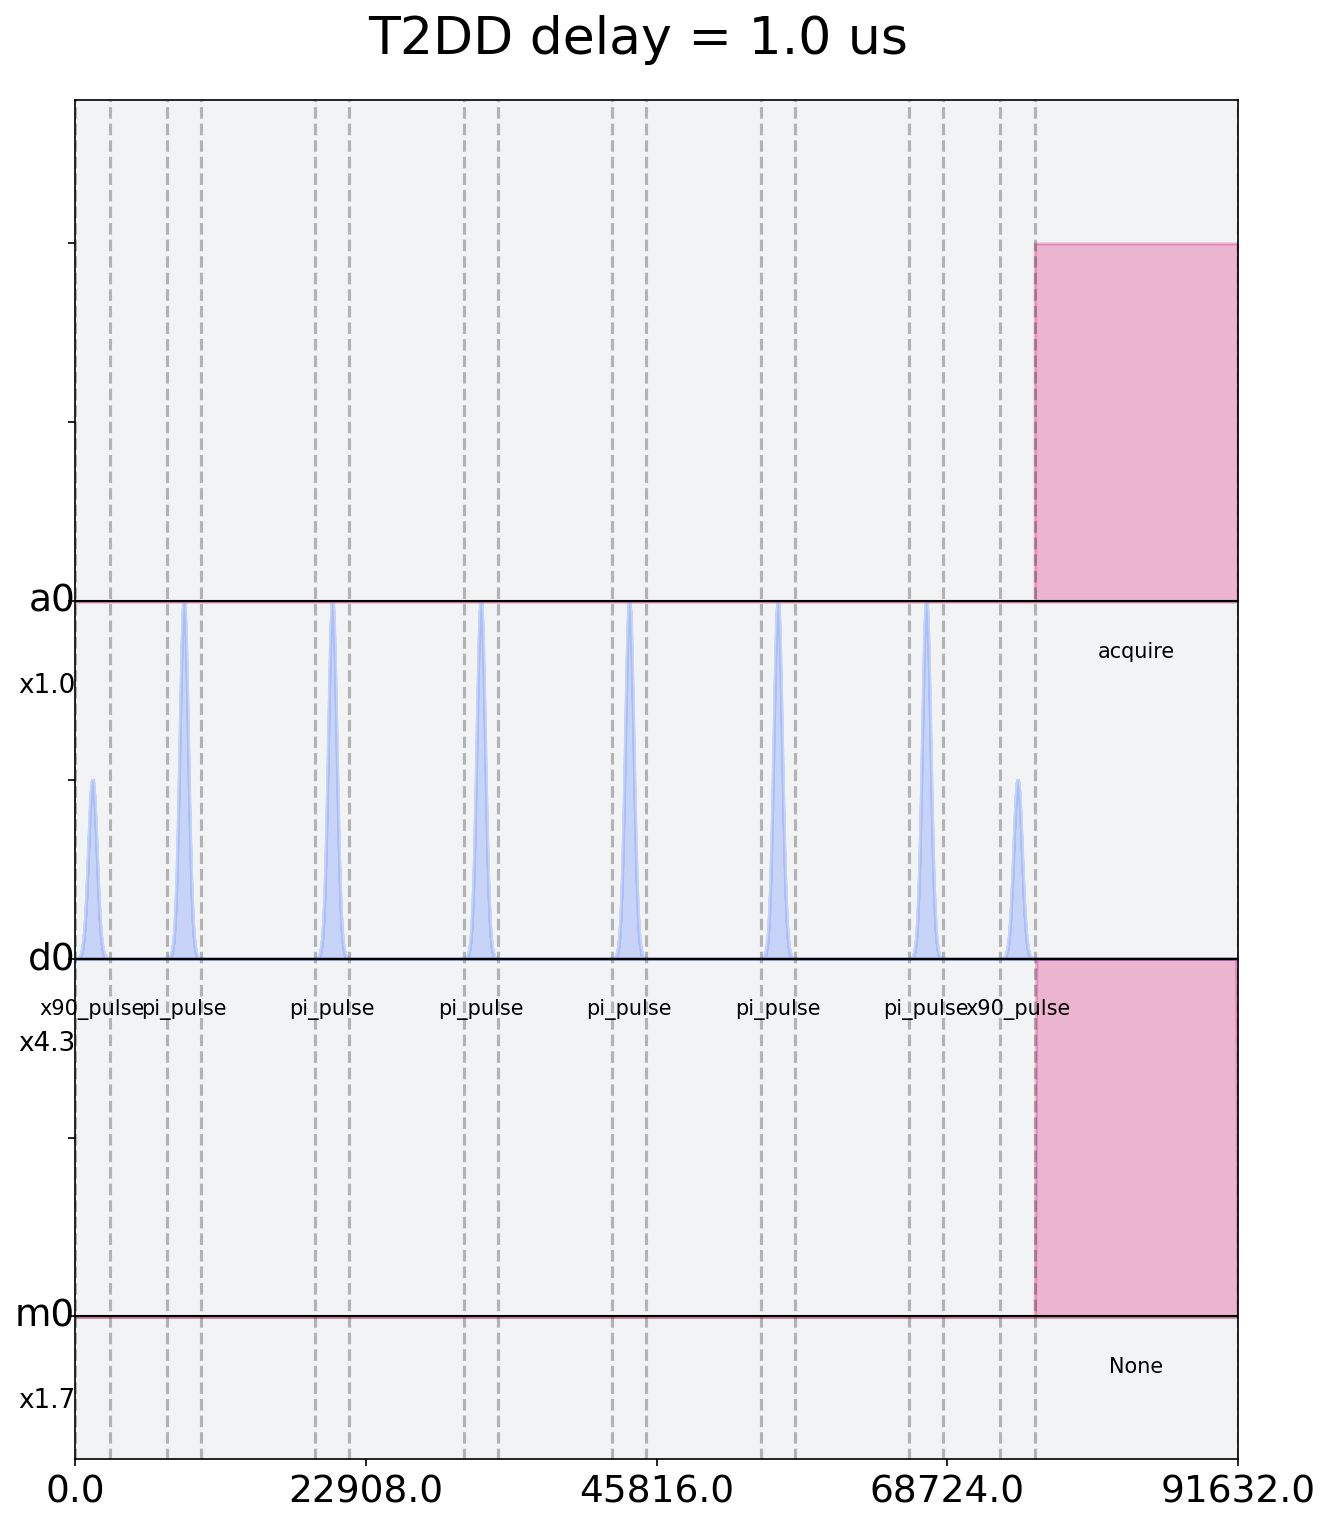

In [73]:
T2DD_schedules[0].draw(label=True)

In [74]:
num_shots_per_point = 1024

T2DD_experiment = assemble(T2DD_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=num_shots_per_point,
                             schedule_los=[{drive_chan: precise_qubit_freq}]
                                          * len(T2DD_schedules))


In [75]:
job = backend.run(T2DD_experiment)
print(job.job_id())
job_monitor(job)

5fd606a885471400194ae125
Job Status: job has successfully run


In [76]:
T2DD_results = job.result(timeout=120)

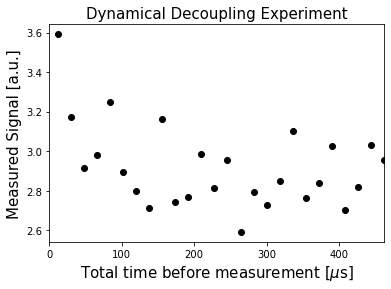

In [77]:
times_us = 2.*num_pi_pulses*taus_us
DD_values = []
for i in range(len(taus_us)):
    DD_values.append(T2DD_results.get_memory(i)[qubit]*scale_factor)

plt.scatter(times_us, np.real(DD_values), color='black')
plt.xlim(0, np.max(times_us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()


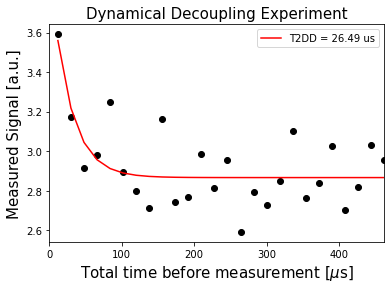

In [78]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_us, np.real(DD_values), [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_us, np.real(DD_values), color='black')
plt.plot(times_us, fit_func(times_us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()
